

---



# ch_06_MLP실습_두번째_MNIST_다층퍼셉트론


In [ ]:
!git clone https://github.com/ballade8/Multi_Layer_Perceptron
#Git Hub 저장소에서 실습 관련 자료를 복제(Clone) 해온다.

Cloning into 'Multi_Layer_Perceptron'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 45 (delta 12), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (45/45), 2.02 MiB | 19.75 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [ ]:
%cd /content/Multi_Layer_Perceptron
#코랩 탭의 파일구조 내에서 위에서 복제한 실습 자료가 있는 폴더로 이동한다.
#학술망에서 저장된 이미지를 출력하기 위해 필요한 코드이다.

/content/Multi_Layer_Perceptron


- 데이터와 모델 예시

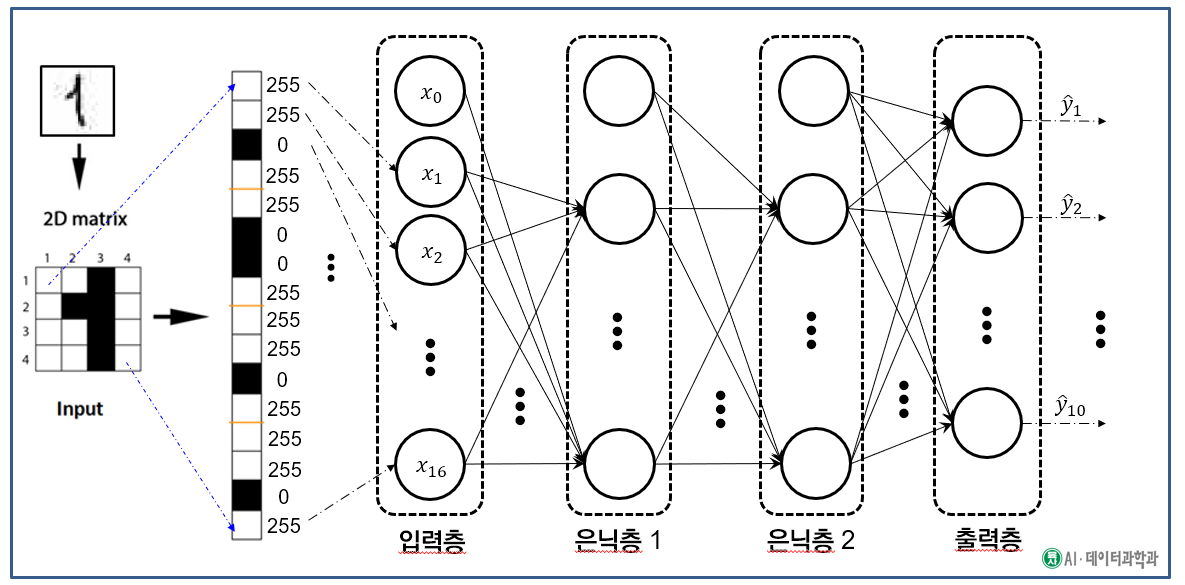

In [ ]:
from PIL import Image # 이미지 출력 함수
Image.open("/content/Multi_Layer_Perceptron/MNIST_MLP_2.png")

## [1] 실습 진행 관련 설명

        - 실습 1번을 토대로 더 복잡한 데이터를 활용하여 다층 퍼셉트론을 구현하고 학습시켜보자.
          본 실습에 사용된 데이터는 MNIST 숫자 손글씨 데이터로, 총 6만장의 훈련 데이터와 1만장의 검증 데이터를 통해
          텐서플로우 라이브러리로부터 간편한 함수들을 활용하여
          다층 퍼셉트론(MLP) 모델이 얼마나 숫자 손글씨를 잘 예측하는지 알아보자.

## [2] 코드 구현의 흐름


        1. (데이터 측면) MNIST 데이터 불러오기

        2. (데이터 확인) MNIST 데이터의 특징 확인

        3. (모델 구현) 텐서플로우 라이브러리로 MLP 모델 구현

        4. (학습 과정) 손실함수와 경사하강법을 설정하고 모델을 학습

        5. (성능 평가) 테스트 데이터를 이용하여 학습된 모델에 대한 성능 평가
        
        6. (모델의 학습 과정 시각화) 정확도와 손실 변화 그래프 관찰


### MNIST 데이터셋을 활용한 다층 퍼셉트론의 다중 클래스 분류

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# 텐서플로우 활용
# 텐서플로우란 머신러닝 라이브러리의 일종으로 머신러닝, 딥러닝 등의 모델 구현을 좀 더 쉽게 구현할 수 있도록 도와주는 라이브러리이다.
# sklearn과 비슷하게 기계학습을 위한 함수들의 묶음으로 생각하자.
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense  # 모델의 세부구성과 관련된 함수  ## 참고로 첫번째 실습 시간에는 Input, Dense 사용
from tensorflow.keras.models import Sequential # 모델을 정의하는 함수 ## 참고로 첫번째 실습 시간에는 Model 사용
from tensorflow.keras.optimizers import SGD # 경사하강법 함수
from tensorflow.keras.losses import SparseCategoricalCrossentropy # 손실함수 정의 ## 참고로 첫번째 실습 시간에는 BinaryCrossentropy 사용
from tensorflow.keras.utils import plot_model # 시각화 함수
from tensorflow.keras.callbacks import ModelCheckpoint


In [ ]:
# seed를 설정하게 되면 random하게 뽑히는 값이 여러번 실행해도 동일한 값이 뽑히게 된다.
# 머신러닝 환경에서 중요한 요소 중 하나는 코드 실행했을 때 나오는 결과를 재현 할 수 있어야하는데, 해당 seed를 설정했을 때는 항상 동일한 값이 나오도록 설정해주는 것이다.
# seed를 변경해가며 random한 가중치의 초기값에 따라 결과가 어떻게 변하는지 확인해보자.
import random
import os

random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

In [ ]:
# 이번 시간부터는 데이터셋의 규모가 크기 때문에 GPU를 활용해보자.
os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.list_physical_devices('GPU')
    except RuntimeError as e:
        print(e)

상기 코드는 GPU를 활용하기 위한 코드여서 다층퍼셉트론의 동작과는 상관이 없다. 하지만 파이썬의 동작 중 "try" "except"문이 등장하였으므로 잠깐 살펴보도록 하자. "try" "except"  프로그램 동작 중 발생하는 예외 상황(예를 들어 정해진 숫자가 아닌 변수로 나눗셈을 하다 보면 0으로 나눗셈을 시도하는 상황이 발생할 수도 있는데, 정상 동작이 아닌 상황을 예외라고 파악해도 충분하다)을 처리하기 위한 방법이다. 위의 코드에서는 "try:" 문 밑에 "tf.config.experimental.list_physical_devices('GPU')" 문이 존재하는데 해당 명령을 실행하다 문제 상황이 발생하면 "except RuntimeError as e:"문에 존재하는 "print(e)"가 실행된다.


#### 1) 데이터 불러오기

- MNIST dataset : Modified National Institute of Standards and Technology


손글씨 숫자 분류 데이터셋으로, 머신러닝과 딥러닝 모델의 교육에 주로 사용되는 표준 데이터 세트를 의미한다.

0 ~ 9까지 10개 클래스의 28 * 28 픽셀 흑백 이미지로 구성되며, 60,000개의 훈련 이미지와 10,000개의 테스트 이미지로 구성되어 있다.

참고로 이미지의 각 픽셀 값의 범위는 0 ~ 255 (shape : uint8) 까지이다. 0은 흑색, 255는 백색을 의미

In [ ]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

# X_train : 그레이스케일 이미지 데이터의 NumPy 배열 (60000, 28, 28).
# 이것은 (28, 28)의 모양을 갖는 입력값이 총 60000개 존재한다는 표현.
# y_train : 숫자 레이블(0-9 범위의 정수) NumPy 배열 (60000,).
# X_test : 그레이스케일 이미지 데이터의 NumPy 배열 (10000, 28, 28), 테스트 데이터.
# y_test : 테스트 데이터의 숫자 레이블(0-9 범위의 정수) NumPy 배열 (10000,).

print(X_train.shape) #=> (60000, 28, 28)
print(y_train.shape) #=> (60000,)
print(X_train[0].shape) #=> (28, 28)
print(X_test.shape) #=> (10000, 28, 28)
print(y_test.shape) #=> (10000,)

11490434/11490434 [==============================] - 2s 0us/step
(60000, 28, 28)
(60000,)
(28, 28)
(10000, 28, 28)
(10000,)


In [ ]:
## 학습 데이터와 테스트 데이터의 각각의 실제값 label 확인
### np.unique : 고유값만 출력해주는 함수.
### return_counts = True : 각 고유값의 개수가 몇 개 인지 알려준다.
print(np.unique(y_train, return_counts = True))
print(np.unique(y_test, return_counts = True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009]))


#### 2) 데이터 특징 확인하기

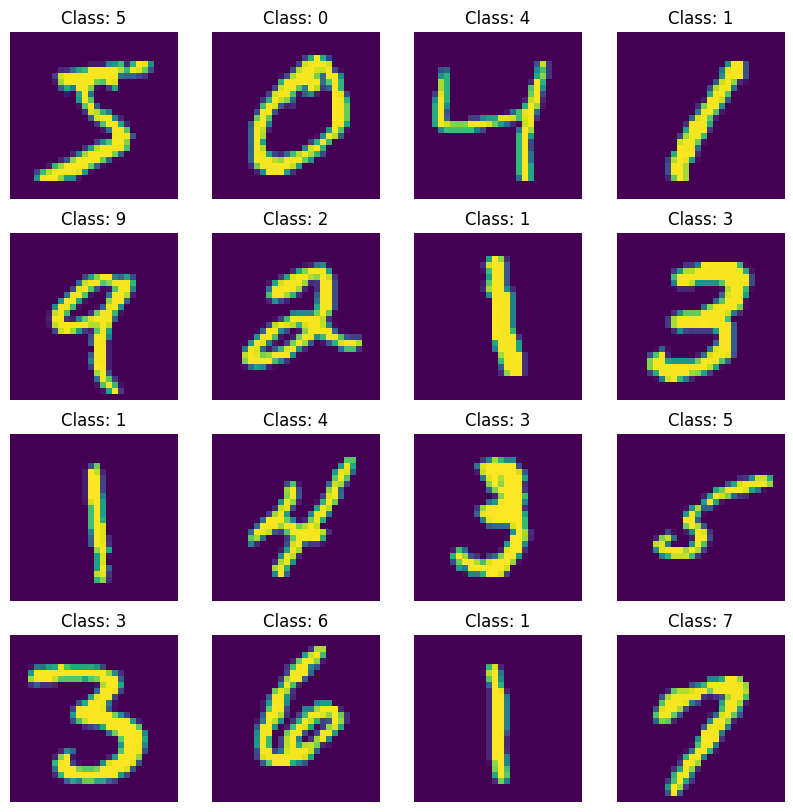

In [ ]:
### 데이터 확인
class_names = ["0","1","2","3","4","5","6","7","8","9"]
## 학습 데이터 예시 16개를 뽑는다.
# images, labels = X_train[:16], y_train[:16].flatten()
images, labels = X_train[:16], y_train[:16]
## 시각화 그림 크기 설정
plt.figure(figsize=(10, 10))
## 16개의 이미지를 4 * 4 배열로 출력해보자.
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i])
    ## 실제값에 맞는 클래스 이름을 찾아서 출력
    plt.title(f"Class: {class_names[labels[i]]}")
    plt.axis("off")

이제 모델을 구현해보도록 하겠습니다. 은닉층이 두개, 은닉 노드는 각각 600개, 500개로 구성된 다층 퍼셉트론을 만들어봅시다.



#### 3) 모델 구현

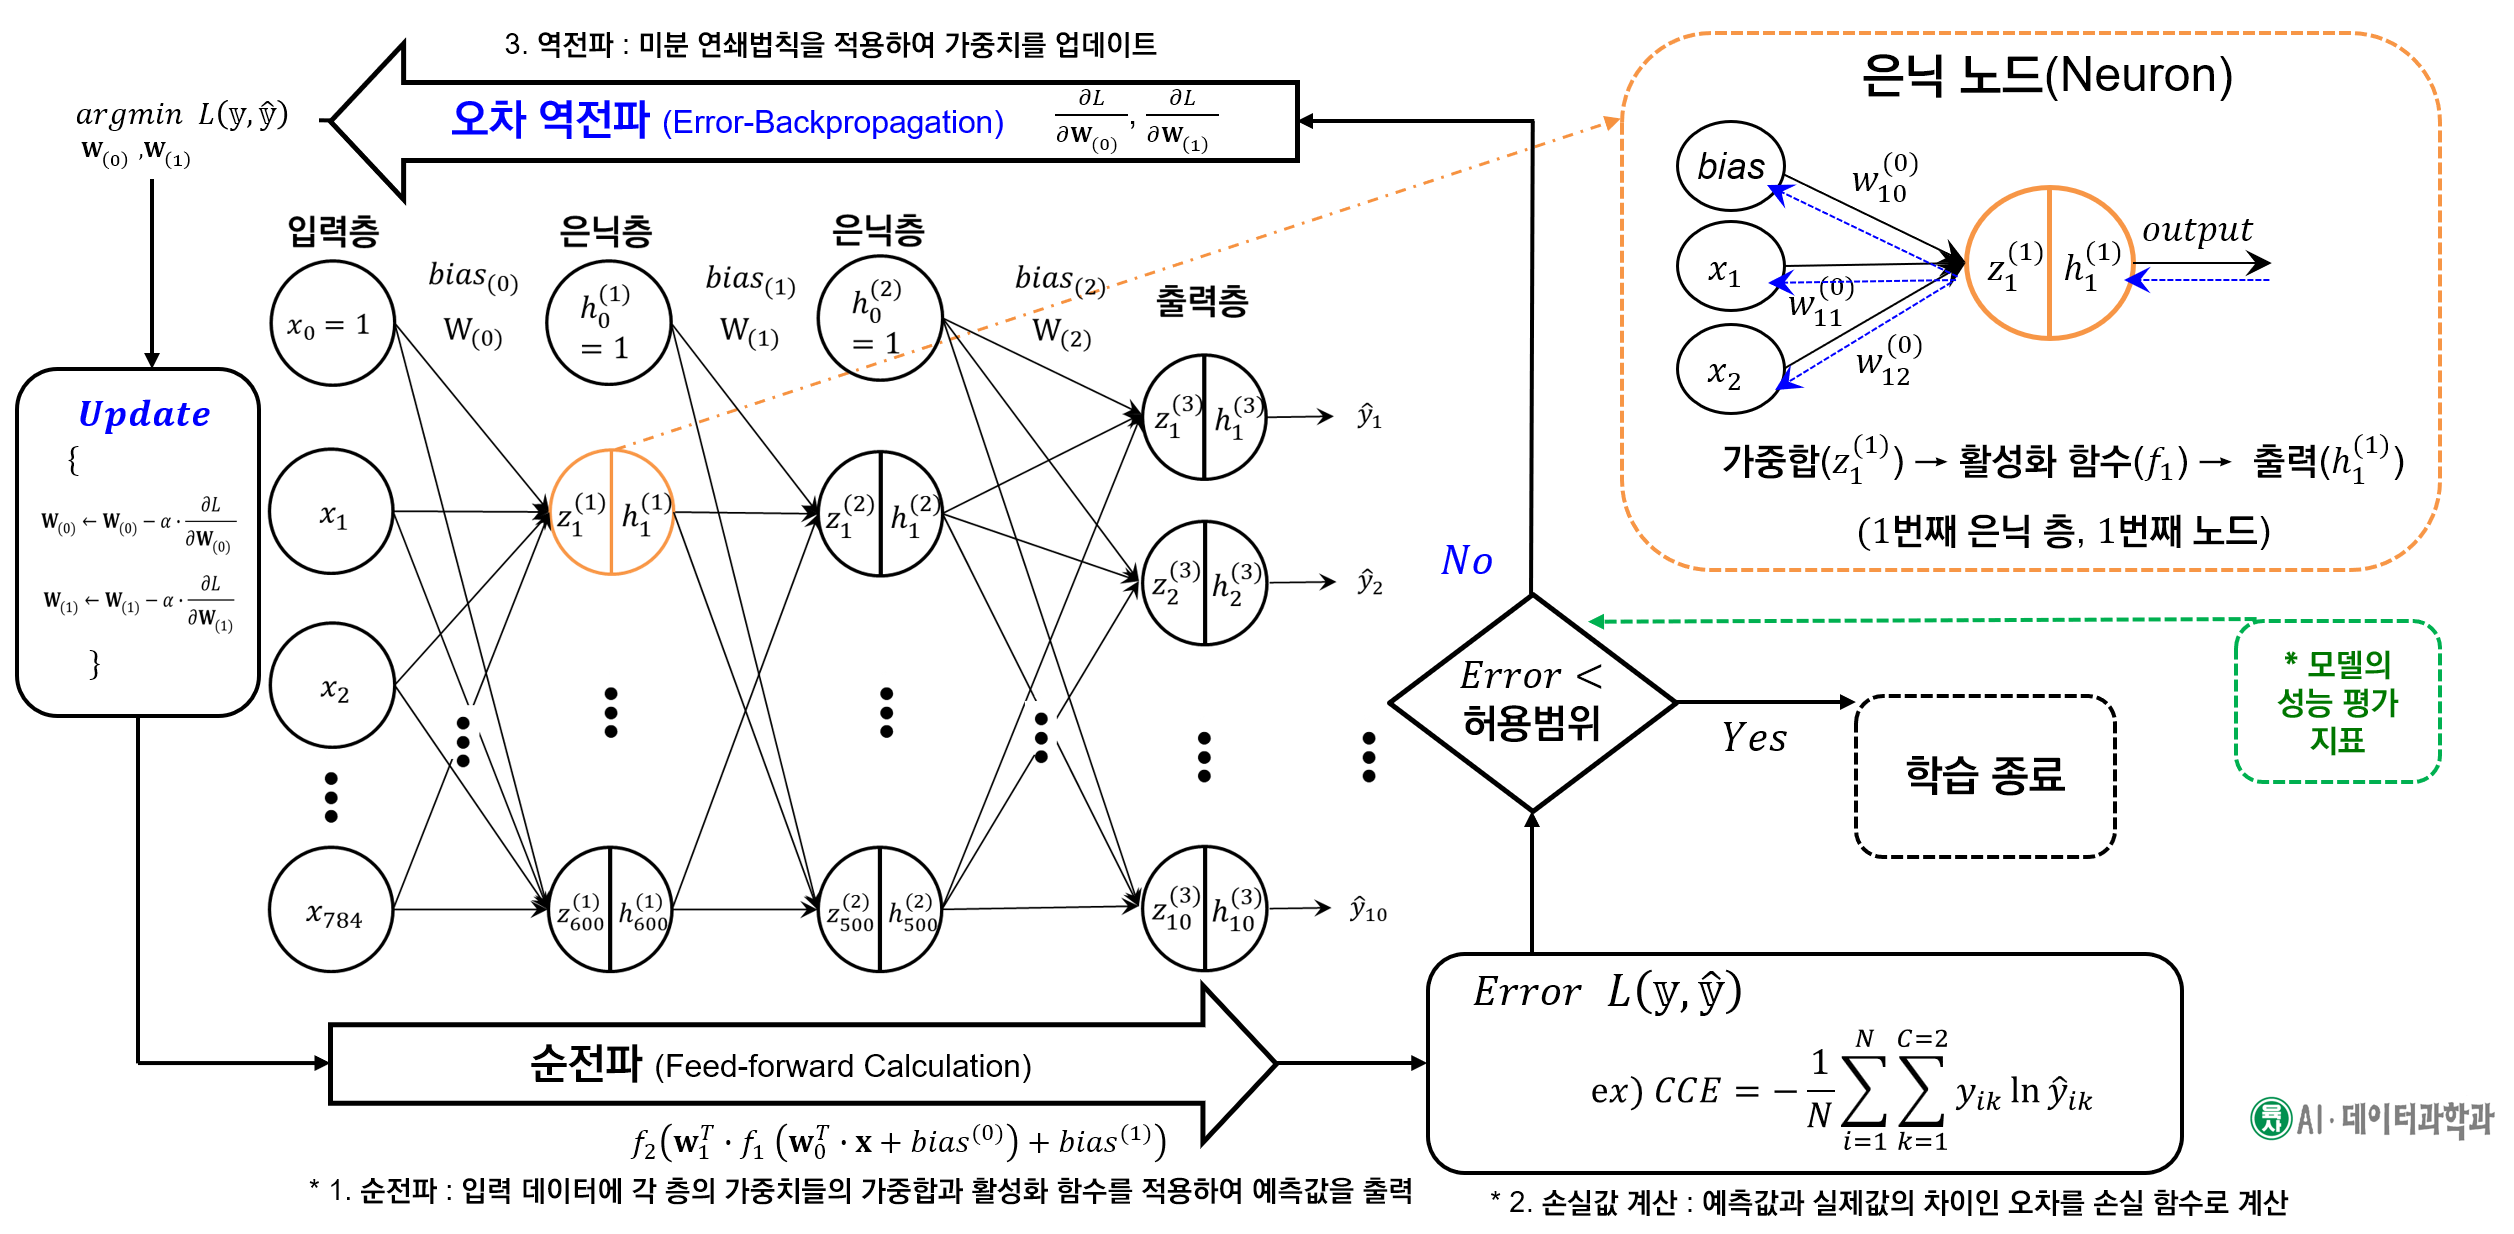

In [ ]:
from PIL import Image # 이미지 출력 함수
Image.open("/content/Multi_Layer_Perceptron/다층퍼셉트론의요약.png")

In [ ]:
# 참고 : 활성화 함수
# relu, softmax 함수
def relu(x):
    return np.maximum(0, x)

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

scores = [3, -2, -1.3, 0, 1.8, 1.7]

print(relu(scores))
print(softmax(scores))


[3.  0.  0.  0.  1.8 1.7]
[0.60833927 0.00409896 0.00825429 0.03028743 0.18322827 0.16579179]


In [ ]:
model = tf.keras.models.Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(600, activation='relu'),
    Dense(500, activation='relu'),
    Dense(10, activation='softmax')
])
## Sequential, Dense 설명 :
   # 연속적인 입력(Sequential Input)으로부터 연속적인 출력(Sequential Output)을 생성하는 모델을 만들어냄.
   # Dense는 실습 1에서 살펴보았다.
   # MLP의 은닉층과 출력층을 구성하는 Dense 함수가 순차적으로 쌓여가는 모델 설계의 과정을 의미하는 함수

## Flatten 설명 :
   # Input 함수 대신에 사용되는 것으로 이미지의 픽셀들이 1차원 배열로 각각 하나씩 입력노드에 매칭되도록 도와줌
   # 즉, 28 * 28 픽셀 데이터를 784개의 입력노드에 매칭 시켜주기 위한 함수


In [ ]:
# 손실함수
# 경우 1. loss = CategoricalCrossentropy()
# 위의 CategoricalCrossentropy()은 입력 데이터의 실제값(라벨 또는 클래스)이 "원-핫 인코딩" 타입일 때, 적용하는 손실함수이다.
# 만약 입력 데이터의 실제값(라벨 또는 클래스)이 "정수" 타입일 경우, 내부적으로 "원-핫 인코딩" 형식으로 입력 데이터의 실제값을 변환하는 과정이 필요하다. 따라서, 이런 경우를 아래 경우 2를 적용하면 편리하다.

# 경우 2. loss = SparseCategoricalCrossentropy()
# 위의 SparseCategoricalCrossentropy()는 입력 데이터의 실제값(라벨 또는 클래스)이 "정수" 타입일 때, 내부적으로 "원-핫 인코딩" 형식으로 자동으로 변환하여 적용되는 손실함수이다.
# 즉, 실습 코드에서 MNIST 데이터의 실제값 Y = 0 ~ 9인 정수 타입으로 제공되고 있으므로, 경우 2의 손실함수를 사용할 경우 Y = [1 0 ... 0] ~ [0 0 ... 1]를 "원-핫 인코딩" 형식으로 변화하는 과정이 필요가 없다.

loss = SparseCategoricalCrossentropy()

# 경사하강법 Gradient Descent
## 확률적 경사 하강법(Stochastic Gradient Descent, SGD)
optimizer = SGD(learning_rate=0.0001)
## 모든 훈련 데이터에 대하여 경사하강법으로 가중치를 업데이트 하는 것이 아니라, SGD는 전체 훈련 데이터를 랜덤하게 섞는 다음에 각 1개 훈련 데이터씩 경사하강법으로 가중치를 업데이트 한다. (전체 훈련데이터 N개를 1개씩 차례대로 경사하강법으로 가중치 업데이트를 반복)
## 경사 하강법의 한계점을 빠른속도와 함께 작은 반복횟수로 어느정도 극복 가능하다

In [ ]:
### 모델 동작 확인
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
#위에서 정의한 학습에 사용되어야할 옵티마이저, 손실함수, 모델 성능 지표를 모델의 인자로 조립(컴파일)해준다.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 600)               471000    
                                                                 
 dense_1 (Dense)             (None, 500)               300500    
                                                                 
 dense_2 (Dense)             (None, 10)                5010      
                                                                 
Total params: 776510 (2.96 MB)
Trainable params: 776510 (2.96 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# 텐서보드를 활용해서 학습 과정과 결과를 실시간으로 모니터링 및 시각화할 수 있다.
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

In [ ]:
### 모델 훈련
# 참고로 with tf.device("/device:GPU:0"): 이 코드가 필요하지 않다.
## 왜냐하면 구글 코랩에서 텐서플로우를 사용할 때는 런타임 GPU를 활성화하면 자동으로 GPU 자원을 사용하여 학습을 진행하기 때문이다.
history = model.fit(X_train, y_train, epochs=50, batch_size=128,
                    validation_data=(X_test, y_test), callbacks=[tensorboard_callback])
## model.fit에 epochs = 50, batch_size=128이라는 인자값이 등장한다.
## 여기서 epochs=50이라는 것은 전체 데이터셋에 대한 학습 과정이 총 50회 진행된다는 뜻인데
## 매 epoch의 구성이 약간 복잡하므로 설명을 해보자.
# 여기서 기억할 것은 "optimizer = SGD(learning_rate=0.0001) "라는 코드이다.
# 즉 Stochastic Gradient Descent (SGD)라는 방식을 사용하고 있는데 SGD는 1개 훈련 관측값에 대하여 손실함수 계산 & 인자 갱신을 수행한다. (여기서 SGD의 batch_size = 1 이다.)

# 하지만 설정값에서 batch_size = 1이 아닌 128으로 설정하였고 이 방식은 Mini-batch Gradient Descent로 학습이 진행된다.
# 현재 코드에서 전체 훈련 관측값 N = 60,000에 대하여 batch_size(=128) 크기의 훈련 관측값을
# 갖는 부분집합들로 분할한다(즉 N/128개의 batch가 존재). 그리고 매 batch(128개의 훈련 관측값으로 구성된)에 대하여 Gradient Descent (GD) 방식을 진행한다.
# (즉, 1개 batch(128개의 훈련 관측값)에 대하여 순전파 계산, 손실함수 계산, 인자 갱신을 실행으로 학습을 진행한다. 이를 1회 iteration 한다.)
# 469개(60,000 / 128 = 468.75 으로 올림)의 batch에 대하여 GD 방식으로 학습(총 469회 iteration)을 완료하면 1회 Epoch가 종료된다.
# 실제 코드 구현 시 Mini-batch Gradient Descent 방법을 많이 사용한다.

Epoch 1/50
469/469 [==============================] - 13s 11ms/step - loss: 6.0503 - accuracy: 0.7936 - val_loss: 2.8990 - val_accuracy: 0.8675
Epoch 2/50
469/469 [==============================] - 5s 11ms/step - loss: 2.2845 - accuracy: 0.8895 - val_loss: 2.0745 - val_accuracy: 0.8966
Epoch 3/50
469/469 [==============================] - 6s 12ms/step - loss: 1.6142 - accuracy: 0.9103 - val_loss: 1.6533 - val_accuracy: 0.9107
Epoch 4/50
469/469 [==============================] - 4s 8ms/step - loss: 1.2598 - accuracy: 0.9241 - val_loss: 1.5094 - val_accuracy: 0.9141
Epoch 5/50
469/469 [==============================] - 3s 7ms/step - loss: 1.0196 - accuracy: 0.9333 - val_loss: 1.3389 - val_accuracy: 0.9190
Epoch 6/50
469/469 [==============================] - 2s 5ms/step - loss: 0.8567 - accuracy: 0.9392 - val_loss: 1.2244 - val_accuracy: 0.9241
Epoch 7/50
469/469 [==============================] - 2s 5ms/step - loss: 0.7233 - accuracy: 0.9456 - val_loss: 1.1589 - val_accuracy: 0.9263
Ep


### 모델 평가

모델이 학습을 모두 완료했다면, 테스트 데이터를 통해 얼마나 잘 맞추는지 검증한다.

313/313 [==============================] - 2s 8ms/step - loss: 0.7980 - accuracy: 0.9420
Test loss: 0.7980270981788635
79/79 [==============================] - 0s 2ms/step
* 검증 데이터의 예측 결과 (예시)
[3.9005806e-31 5.2993315e-28 3.5710803e-17 1.2570941e-13 0.0000000e+00
 2.1995314e-26 0.0000000e+00 1.0000000e+00 6.8597597e-19 5.3366856e-18]
* 예측 클래스 (예시)
7
* Metrics
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       980
           1       0.98      0.98      0.98      1135
           2       0.94      0.92      0.93      1032
           3       0.92      0.95      0.93      1010
           4       0.94      0.95      0.94       982
           5       0.92      0.93      0.92       892
           6       0.96      0.95      0.95       958
           7       0.95      0.95      0.95      1028
           8       0.92      0.91      0.92       974
           9       0.92      0.92      0.92      1009

    accuracy                           0.9

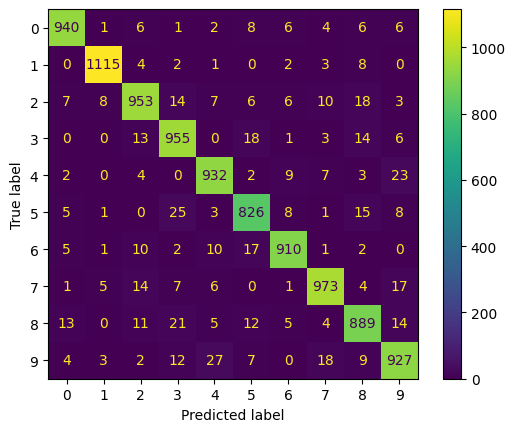

In [ ]:
# 모델에 테스트 데이터를 입력하여 학습 과정을 제외한 순전파 과정을 거친다.
# X_test에 대한 모델의 출력값과 정답인 y_test를 비교하여 성능을 평가함에 주의
loss, accuracy = model.evaluate(X_test, y_test)

print('Test loss:', loss)

# 기존에 배운 sklearn의 성능 지표 출력으로 모델을 검증한다
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
y_pred = model.predict(X_test, batch_size=128) # 배치 사이즈

print("* 검증 데이터의 예측 결과 (예시)")
print(y_pred[0])
y_pred_one_hot = np.argmax(y_pred, axis=1)
print("* 예측 클래스 (예시)")
print(y_pred_one_hot[0])


print("* Metrics") # accuracy를 관찰해보자.
print(classification_report(y_test, y_pred_one_hot, zero_division=0))

print("* Confusion matrix") # 혼동 행렬 confusion matrix를 관찰해보자.
cf = confusion_matrix(y_test, y_pred_one_hot)
ConfusionMatrixDisplay(cf).plot()

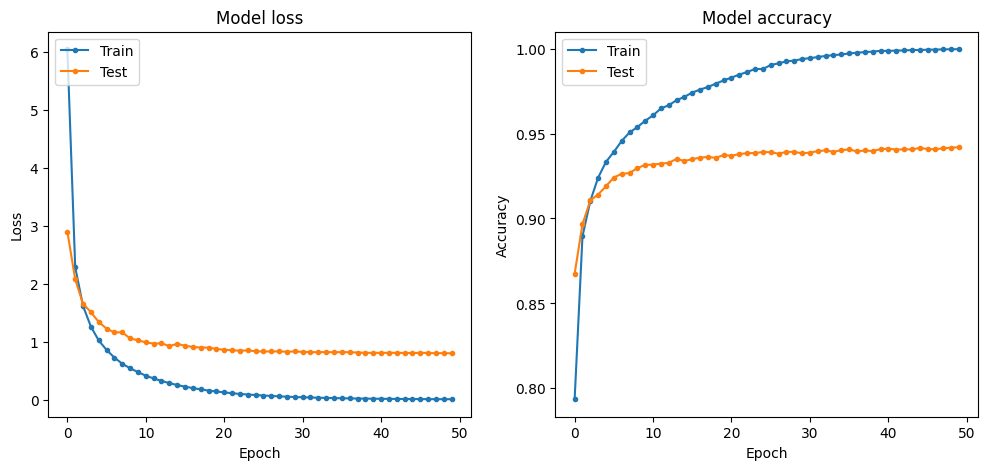

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# 훈련 및 테스트 과정 시각화 (손실)
ax1.plot(history.history['loss'],marker = '.', label = "Train loss")
ax1.plot(history.history['val_loss'],marker = '.', label = "Valid loss")
ax1.set_title('Model loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(['Train', 'Test'], loc='upper left')

# 훈련 및 테스트 과정 시각화 (정확도)
ax2.plot(history.history['accuracy'],marker = '.', label = "Train accuracy")
ax2.plot(history.history['val_accuracy'],marker = '.', label = "Valid accuracy")
ax2.set_title('Model accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend(['Train', 'Test'], loc='upper left')

plt.show()

### 마치며

이처럼 MNIST와 같이 단순한 흑백 이미지의 경우, 다층퍼셉트론(MLP)을 이용해서 높은 분류 성능을 얻을 수 있다.

그러나, 실제로 많이 사용되는 전처리가 완료된 이미지 데이터(ex. Cifar, ImageNet ...)들은 RGB의 3채널 컬러 이미지로 픽셀의 개수가 매우 많고 클래스의 종류도 수 백가지 이상으로 증가하기 때문에 MLP의 은닉층을 많이 쌓아도 분류 성능에 한계점이 발생한다. 또한 모델의 파라미터가 증가함에 따라 연산 비용(하드웨어 비용, 고성능 GPU 등)이 비약적으로 증가하게 되었다.

이후 convolution 연산이라는 이미지의 2차원 공간 정보의 특징을 나타낼 수 있는 연산을 활용한 CNN (Convolutional Neural Network) 모델이 등장하면서 이미지 인식 성능이 획기적으로 높아지게 되어, 인공지능 분야는 또다시 크게 주목받게 되었다.

최근 등장하는 Chat-gpt, Dalle-2, Bard 와 같은 거대 생성 AI 모델 또한 다층 퍼셉트론과 비슷한 메커니즘으로 가중치를 업데이트하는 방식을 기반으로 하고 있다는 점을 인지하길 바랍니다.